### Imports

In [1]:
%load_ext autoreload

In [2]:
import os
import seaborn as sns
import torch
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor, TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.utilities.model_summary import ModelSummary
from lightning_fabric.utilities.seed import seed_everything

In [3]:
%autoreload
from celldreamer.estimator.estimator import EstimatorAutoEncoder

In [4]:
# config parameters
MODEL = 'cellnet'
root = os.path.dirname(os.path.abspath(os.getcwd()))
CHECKPOINT_PATH = os.path.join(root, 'trained_models/tb_logs', MODEL)
LOGS_PATH = os.path.join(root, 'trained_models/tb_logs', MODEL)
DATA_PATH = '/lustre/scratch/users/felix.fischer/merlin_cxg_norm_parquet'

### Explore MLP Autoencoder with CellNet

In [5]:
estim = EstimatorAutoEncoder(DATA_PATH)
seed_everything(1)

[rank: 0] Global seed set to 1


1

In [6]:
estim.init_datamodule(batch_size=4096)

In [7]:
estim.init_trainer(
    trainer_kwargs={
        'max_epochs': 1000,
        'gradient_clip_val': 1.,
        'gradient_clip_algorithm': 'norm',
        'default_root_dir': CHECKPOINT_PATH,
        'accelerator': 'gpu',
        'devices': 1,
        'num_sanity_val_steps': 0,
        'check_val_every_n_epoch': 1,
        'logger': [TensorBoardLogger(LOGS_PATH, name='default')],
        'log_every_n_steps': 100,
        'detect_anomaly': False,
        'enable_progress_bar': True,
        'enable_model_summary': False,
        'enable_checkpointing': True,
        'callbacks': [
            TQDMProgressBar(refresh_rate=100),
            LearningRateMonitor(logging_interval='step'),
            ModelCheckpoint(filename='best_train_loss', monitor='train_loss_epoch', mode='min',
                            every_n_epochs=1, save_top_k=1),
            ModelCheckpoint(filename='best_val_loss', monitor='val_loss', mode='min',
                            every_n_epochs=1, save_top_k=1)
        ],
    }
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [8]:
estim.init_model(
    model_type='mlp',
    model_kwargs={
        'learning_rate': 0.005,
        'weight_decay': 0.1,
        'lr_scheduler': torch.optim.lr_scheduler.StepLR,
        'units_encoder': [512, 512, 256, 256, 64],
        'units_decoder': [64, 256, 256, 512, 512],
        'lr_scheduler_kwargs': {
            'step_size': 2,
            'gamma': 0.9,
            'verbose': True
        },
        'optimizer': torch.optim.AdamW,
    },
)

In [9]:
print(ModelSummary(estim.model))

  | Name          | Type             | Params
---------------------------------------------------
0 | train_metrics | MetricCollection | 0     
1 | val_metrics   | MetricCollection | 0     
2 | test_metrics  | MetricCollection | 0     
3 | encoder       | MLP              | 10.4 M
4 | decoder       | Sequential       | 10.4 M
---------------------------------------------------
20.8 M    Trainable params
0         Non-trainable params
20.8 M    Total params
83.219    Total estimated model params size (MB)


### Find learning rate

In [10]:
lr_find_res = estim.find_lr(
    lr_find_kwargs={'early_stop_threshold': 10., 
                    'min_lr': 1e-8, 
                    'max_lr': 10., 
                    # 'cpkt_path': '/home/icb/till.richter/git/celldreamer/trained_models',
                    'num_training': 120})

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Adjusting learning rate of group 0 to 5.0000e-03.


Finding best initial lr:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 74/120 [00:33<00:21,  2.18it/s]
LR finder stopped early after 74 steps due to diverging loss.
Restoring states from the checkpoint path at /home/icb/till.richter/git/celldreamer/trained_models/tb_logs/cellnet/.lr_find_f45b98b4-2172-412b-a961-6c647f23c168.ckpt
Restored all states from the checkpoint file at /home/icb/till.richter/git/celldreamer/trained_models/tb_logs/cellnet/.lr_find_f45b98b4-2172-412b-a961-6c647f23c168.ckpt


Suggested learning rate: 0.0029853826189179563


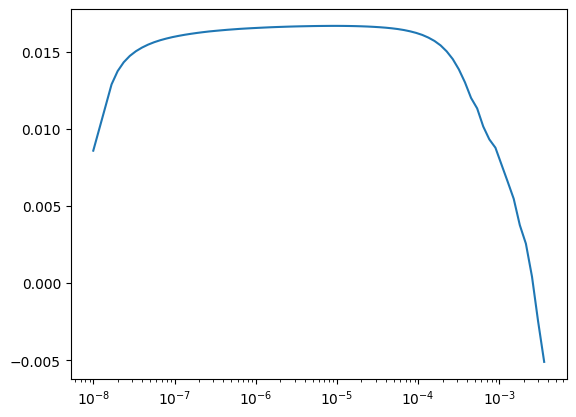

In [11]:
ax = sns.lineplot(x=lr_find_res[1]['lr'], y=lr_find_res[1]['loss'])
ax.set_xscale('log')
# ax.set_ylim(12., top=20.)
# ax.set_xlim(1e-6, 10.)
print(f'Suggested learning rate: {lr_find_res[0]}')

### Train

In [12]:
# Train takes a while, but this is how it's called in a script:
# estim.train()